In [6]:
import random
from collections import OrderedDict
import time


class MemoryInstruction:
    def __init__(self, processId, readWriteFlag, virtualAddress):
        self.processId = processId
        self.virtualAddress = virtualAddress
        # self.readWriteFlag = readWriteFlag
        self.virtualPage = virtualAddress >> 12
    def __lt__(self, other):
        return self.processId < other.processId or self.virtualPage < other.virtualPage
    def __str__(self):
        return (self.processId,self.virtualAddress,self.virtualPage).__str__()
    def __eq__(self, other):
        return self.virtualPage == other.virtualPage and self.processId == other.processId

    def __hash__(self):
        return hash((self.processId, self.virtualPage))


class Trace:
    def __init__(self, n, mmu):
        self.queue = []
        self.max_size = n
        self.mmu = mmu
    def add(self, item):
        if len(self.queue) == self.max_size:
            self.queue.pop(0)
        self.queue.append(item)

    # demoted_threshold=3 , Demote if 3 or less pages in a superpage are touched
    def get_promoted_demoted_pages(self,*,demoted_threshold=3,):
        start_time = time.time()
        distinct2 = {}
        distinct_items = []
        for item in self.queue:
            if (item.virtualPage,item.processId) not in distinct2:
                distinct_items.append(item)
                distinct2[(item.virtualPage,item.processId)] = 1
        sorted_memory_access = sorted(distinct_items)
        demoted_pages = {}
        i = 0
        while i < len(sorted_memory_access):
            #  # print(i,"ENTERED")
            super_page_number = sorted_memory_access[i].virtualPage // 4
            processId = sorted_memory_access[i].processId
            if self.mmu.pid_spte_mapping[processId].does_mapping_exist(super_page_number):
                j = i+1
                count = 1
                while j < len(sorted_memory_access):
                    candidate_super_page_number = sorted_memory_access[j].virtualPage // 4
                    candidate_processId = sorted_memory_access[j].processId
                    if candidate_super_page_number==super_page_number and candidate_processId==processId:
                        count += 1
                    else:
                        if count<=demoted_threshold:
                            if processId in demoted_pages:
                                demoted_pages[processId].append(super_page_number)
                            else:
                                demoted_pages[processId] = [super_page_number]
                        i = j-1
                        count = 0
                        break
                    j += 1
            i = i + 1

        promoted_pages = {}
        for i in range(len(sorted_memory_access)):

            page_number = sorted_memory_access[i].virtualPage
            processId = sorted_memory_access[i].processId
            # Checks if the page is the starting base page in a super page and see if the next 3 pages also are accessed, then promote
            if page_number % 4 == 0 and i+3<len(sorted_memory_access) and sorted_memory_access[i+3].processId==processId \
                    and sorted_memory_access[i+3].virtualPage == page_number+3 \
                    and not self.mmu.pid_spte_mapping[processId].does_mapping_exist(page_number//4):
                if not (self.mmu.pid_pte_mapping[processId].does_mapping_exist(page_number)
                        and self.mmu.pid_pte_mapping[processId].does_mapping_exist(page_number+1)
                        and self.mmu.pid_pte_mapping[processId].does_mapping_exist(page_number+2)
                        and self.mmu.pid_pte_mapping[processId].does_mapping_exist(page_number+3)):
                    raise Exception(f"Trying to promote 4 pages starting from {page_number}, for pid:{processId}"
                                    f" for which pte entry doesn't exist")
                if processId in promoted_pages:
                    promoted_pages[processId].append(page_number)
                else:
                    promoted_pages[processId] = [page_number]

        # print("promoted_pages: mapping from processId to starting base page to be promoted",promoted_pages)
        end_time = time.time()
        execution_time = end_time - start_time
        print("Promotion Demotion execution time:", execution_time)

        return demoted_pages,promoted_pages

class RAM:
    def __init__(self):
        self.free_superpage_list = [(0, 2**32-1)]
        self.free_page_list = [(0,2**34-1)]
        self.base_page_process_mapping = {}
        self.super_page_process_mapping = {}
    def evict_page(self, page):
        raise SwapNotImplemented("SwapNotImplemented")

    def merge(self,intervals):
        if not intervals:
            return []
        # print("Intervals :", intervals)
        intervals.sort(key=lambda x: x[0])
        merged = [intervals[0]]

        for interval in intervals[1:]:
            if interval[0]  <= merged[-1][1] +1:
                merged[-1] = (merged[-1][0], max(merged[-1][1], interval[1]))
            else:
                merged.append(interval)

        return merged

    def has_empty_pages(self):
        return len(self.free_page_list)==0 and len(self.free_superpage_list)==0

    def allocate_empty_page(self,alloc_requirement_is_super,process_id):
        page = self.allocate_memory(alloc_requirement_is_super,process_id)
        if alloc_requirement_is_super:
            self.super_page_process_mapping[page] = process_id
        else:
            self.base_page_process_mapping[page] = process_id
        return page

    def is_number_in_intervals(self, number, intervals):
        left = 0
        right = len(intervals) - 1

        while left <= right:
            mid = (left + right) // 2
            interval = intervals[mid]

            if interval[0] <= number <= interval[1]:
                return True
            elif interval[0] > number:
                right = mid - 1
            else:
                left = mid + 1

        return False

    def add_single_pages_to_free_list(self,single_pages):

        # print("single pages to add :",single_pages)
        self.free_page_list.extend([(p,p) for p in single_pages])
        self.free_page_list = self.merge(self.free_page_list)
        # print("free page list after adding single pages :",self.free_page_list)
        for page in single_pages:
            basepage = (page//4)*4
            count = 0
            for i in range(4):
                if(self.is_number_in_intervals(page+i,self.free_page_list)):
                    count+=1
            if count == 4:
                self.free_superpage_list.append((basepage//4,basepage//4))
                # print("Superpage list before merging:",self.free_superpage_list)
                self.free_superpage_list = self.merge(self.free_superpage_list)
                # print("Superpage list after merging:",self.free_superpage_list)


    def map_page_to_process(self,page_num, process_id):
        self.page_table[page_num] = process_id

    def map_superpage_to_process(self,super_page_num,process_id):
        self.super_page_table[super_page_num]  = process_id

    def remove_from_free_list(self,free_list,pages_to_remove):
        updated_free_page_list = []
        #  # print("AAAAA",self.free_page_list)
        current_start = free_list[0][0]

        for page_range in free_list:
            start, end = page_range

            # Check if any pages to be removed fall within this range
            if start <= pages_to_remove[0] and end >= pages_to_remove[-1]:
                # Add range of pages before the ones to be removed
                if current_start < pages_to_remove[0]:
                    updated_free_page_list.append((current_start, pages_to_remove[0] - 1))

                # Move the start pointer to after the pages to be removed
                current_start = pages_to_remove[-1] + 1

                # If there are more pages after the ones to be removed, add the range to the updated list
                if end > pages_to_remove[-1]:
                    updated_free_page_list.append((current_start, end))

            # If the current range doesn't contain any pages to be removed, just add it to the updated list
            else:
                updated_free_page_list.append((start, end))

        return updated_free_page_list


    def allocate_memory(self,alloc_requirement_is_super,process_id):
        # IF RAM IS NOT FULL
        if alloc_requirement_is_super:
            if len(self.free_superpage_list) > 0:
                # get the last element of the super page list
                superpage = self.free_superpage_list.pop()
                start, end = superpage

                # add the remaining free space to the super page list
                if start + 1 <= end:
                    self.free_superpage_list.append((start + 1, end))
                # remove corresponding single pages from free_page_list
                free_page_start = 4 * (start)
                free_page_end = 4 * (start) + 3
                pages_to_remove = [free_page_start,free_page_start+1,free_page_start+2,free_page_start+3]
                self.super_page_process_mapping[start] = process_id
                # print("BEFORE REMOVING CORRESPONFING SINGLE PAGE",self.free_page_list,pages_to_remove)
                self.free_page_list = self.remove_from_free_list(self.free_page_list,pages_to_remove)
                # print("AFTER REMOVING CORRESPONFING SINGLE PAGE",self.free_page_list)
                return start
            else:
                return None

        # IF RAM IS FULL

        # That means no superpages are available
        #  Swap from a random process physical pages using Page tables

        else:
            if len(self.free_page_list) > 0:
                page = self.free_page_list.pop()
                start, end = page
                if start + 1 <= end:
                    self.free_page_list.append((start + 1, end))

                superpage = start // 4
                self.free_superpage_list = self.remove_from_free_list(self.free_superpage_list,[superpage])
                return start
            else:
                raise MemoryFull("RAM is full")
                # return swapmemory(process_id)



class TLBMiss(Exception):
    pass


class PageFault(Exception):
    pass

class MemoryFull(Exception):
    pass

class SwapNotImplemented(Exception):
    pass

class TLB:
    def __init__(self,tlbSize):
        self.processID = None
        self.mapping = OrderedDict()
        self.tlbSize = tlbSize
    def __str__(self):
        return f"TLB Mapping: {self.mapping}"

    def get_entry(self, virtual_page):
        if virtual_page in self.mapping:
            self.mapping.move_to_end(virtual_page)
            return self.mapping[virtual_page]
        else:
            raise TLBMiss(f"TLB miss: virtual page {virtual_page} has no physical page mapping.")

    def add_entry(self, virtual_page, physical_page):
        self.mapping[virtual_page] = physical_page
        # If the TLB has more than 10 entries, remove the least recently used one
        if len(self.mapping) > self.tlbSize:
            self.mapping.popitem(last=False)

    def clear_TLB(self):
        self.processID = None
        self.mapping = OrderedDict()

    def remove_entry(self, virtual_page):
        if virtual_page in self.mapping:
            del self.mapping[virtual_page]


class STLB:
    def __init__(self,stlbSize):
        self.processID = None
        self.mapping = OrderedDict()
        self.stlbSize = stlbSize
    def __str__(self):
        return f"STLB Mapping: {self.mapping}"
    def get_entry(self, virtual_page):
        if virtual_page in self.mapping:
            self.mapping.move_to_end(virtual_page)
            return self.mapping[virtual_page]
        else:
            raise TLBMiss(f"TLB miss: virtual page {virtual_page} has no physical page mapping.")

    def add_entry(self, virtual_page, physical_page):
        self.mapping[virtual_page] = physical_page
        # If the TLB has more than 10 entries, remove the least recently used one
        if len(self.mapping) > self.stlbSize:
            self.mapping.popitem(last=False)

    def remove_entry(self, virtual_page):
        if virtual_page in self.mapping:
            del self.mapping[virtual_page]

    def clear_STLB(self):
        self.processID = None
        self.mapping = OrderedDict()



class PTE:
    def __init__(self):
        self.processID = None
        self.__mapping = OrderedDict()
    def __str__(self):
        return f"PTE Mapping: {self.__mapping}"

    def getTotalEntries(self):
        return len(self.__mapping)

    def get_physical_page(self, virtual_page):
        if virtual_page not in self.__mapping:
            raise PageFault(f"Page fault: virtual page {virtual_page} does not exist.")
        elif self.__mapping[virtual_page] is None:
            # If the physical page is None, generate a page fault
            raise PageFault(f"Page fault: virtual page {virtual_page} has no physical page mapping.")
        else:
            self.__mapping.move_to_end(virtual_page)
            physical_page = self.__mapping[virtual_page]
            return physical_page

    def does_mapping_exist(self, virtual_page):
        return virtual_page in self.__mapping

    def add_pte_mapping(self,virtual_page,physical_page):
        self.__mapping[virtual_page] = physical_page

    def remove_entry(self, virtual_page):
        physical_page = self.__mapping[virtual_page]
        del self.__mapping[virtual_page]
        return physical_page


class SPTE:
    def __init__(self):
        self.processID = None
        self.__mapping = OrderedDict()
    def __str__(self):
        return f"SPTE Mapping: {self.__mapping}"

    def getTotalEntries(self):
        return len(self.__mapping)

    def get_physical_page(self, virtual_page):
        if virtual_page not in self.__mapping:
            # If the virtual page is not in the mapping, generate a page fault
            raise PageFault(f"Page fault: virtual page {virtual_page} does not exist.")
        elif self.__mapping[virtual_page] is None:
            # If the physical page is None, generate a page fault
            raise PageFault(f"Page fault: virtual page {virtual_page} has no physical page mapping.")
        else:
            # If the mapping exists, move the virtual page to the end so that the first element denotes the LRU entry
            self.__mapping.move_to_end(virtual_page)
            physical_page = self.__mapping[virtual_page]
            return physical_page

    def does_mapping_exist(self, virtual_page):
        return virtual_page in self.__mapping
    def add_spte_mapping(self, virtual_page, physical_page):
        if virtual_page in self.__mapping:
            raise Exception("Trying to add a virtual super page mapping when the the mapping already exists")
        # Add a virtual-to-physical page mapping to the mapping dictionary
        self.__mapping[virtual_page] = physical_page

    def remove_entry(self, virtual_page):
        del self.__mapping[virtual_page]


class MMU:
    def __init__(self,*,tlbSize,stlbSize):
        self.pid_spte_mapping = {}
        self.pid_pte_mapping = {}
        self.page_metadata = {}
        self.tlb = TLB(tlbSize)
        self.stlb = STLB(stlbSize)
        self.RAM = RAM()  # 2^36 pages in RAM, each page is 2^12 bytes -- Total 48 bits
        self.tlbMisses = 0
        self.distinct = {}
        # maintain same variable for tlb mapping and pid_pte_mapping

    def getTotalPTEEntries(self):
        count = 0
        for pid in self.pid_pte_mapping:
            count += self.pid_pte_mapping[pid].getTotalEntries()
        return count

    def getTotalSPTEEntries(self):
        count = 0
        for pid in self.pid_spte_mapping:
            count += self.pid_spte_mapping[pid].getTotalEntries()
        return count

    def initialize_page_table_for_process(self, processID):
        # Initialize a new PTE table for the given processID and add it to the mapping
        self.pid_pte_mapping[processID] = PTE()
        self.pid_pte_mapping[processID].processID = processID

    def initialize_superpage_table_for_process(self, processID):
        self.pid_spte_mapping[processID] = SPTE()
        self.pid_spte_mapping[processID].processID = processID

    def clear_TLB(self):
        # Clear the TLB by reinitializing it
        self.tlb.clear_TLB()

    def get_physical_address(self, ins: MemoryInstruction, *, reservation=False):
        processId = ins.processId
        virtual_address = ins.virtualAddress
        if processId not in self.pid_pte_mapping:
            self.initialize_page_table_for_process(processId)
            self.initialize_superpage_table_for_process(processId)
        virtual_page = virtual_address >> 12
        # Check if the physical address is in the TLB
        try:
            virtual_super_page = virtual_page // 4
            if virtual_super_page in self.stlb.mapping:
                super_physical_page = self.stlb.mapping[virtual_super_page]
                offset = virtual_address & 0x3FFF
                physical_address = (super_physical_page << 14) | offset
                return physical_address
            else:
                physical_page = self.tlb.get_entry(virtual_page)
                offset = virtual_address & 0xFFF
                physical_address = (physical_page << 12) | offset
                return physical_address
        except TLBMiss as e:
            self.tlbMisses += 1
            try:
                # Look up the PTE entry for the processID
                pte_entry = self.pid_pte_mapping[processId]
                physical_page = pte_entry.get_physical_page(virtual_page)
                self.tlb.add_entry(virtual_page, physical_page)
                offset = virtual_address & 0xFFF
                physical_address = (physical_page << 12) | offset
                return physical_address
            except PageFault as e:
                # Check in SPTE....
                try:
                    virtual_super_page = virtual_page // 4
                    spte_entry = self.pid_spte_mapping[processId]
                    super_physical_page = spte_entry.get_physical_page(virtual_super_page)
                    self.stlb.add_entry(virtual_super_page, super_physical_page)
                    offset = virtual_address & 0x3FFF
                    physical_address = (super_physical_page << 14) | offset
                    return physical_address
                except PageFault as e:

                    if reservation:
                        # Allocate a super page
                        virtual_super_page = virtual_page // 4
                        super_physical_page = self.get_free_page(processId,reservation=reservation)
                        self.add_spte_mapping(processId, virtual_super_page, super_physical_page)
                        self.stlb.add_entry(virtual_super_page,super_physical_page)
                        offset = virtual_address & 0x3FFF
                        physical_address = (super_physical_page << 14) | offset
                        return physical_address
                    else:
                        physical_page = self.get_free_page(processId,reservation=reservation)
                        self.add_pte_mapping(processId, virtual_page, physical_page)
                        self.tlb.add_entry(virtual_page, physical_page)
                        offset = virtual_address & 0xFFF
                        physical_address = (physical_page << 12) | offset
                        return physical_address


        raise Exception("Unxpected End")


    def get_free_page(self,processId,*,reservation=False):
        # Get a free physical page from the unused_pages set, or evict an LRU page
        if not self.RAM.has_empty_pages():
            physical_page = self.RAM.allocate_empty_page(reservation,processId)
        else:
            # pick a process with maximum pages in PTE entry and evict it to harddisk
            print("No empty pages in RAm")
            processID, virtual_page = max(self.pid_pte_mapping.items(), key=lambda x: len(x[1].mapping))
            virtual_page, physical_page = self.pid_pte_mapping[processID].evict_lru_page()
        return physical_page

    def add_pte_mapping(self, processID, virtual_page, physical_page):
        # Add a virtual-to-physical page mapping to the PTE entry for the given processID
        pte_entry = self.pid_pte_mapping[processID]
        if virtual_page not in self.distinct:
            # print("Virtual page, pid",virtual_page,processID)
            self.distinct[virtual_page]=1
        pte_entry.add_pte_mapping(virtual_page,physical_page)

    def add_spte_mapping(self, processID, virtual_page, physical_page):
        # Add a virtual-to-physical page mapping to the PTE entry for the given processID
        pte_entry = self.pid_spte_mapping[processID]
        pte_entry.add_spte_mapping(virtual_page,physical_page)

    def remove_spte_mapping(self, processID):
        # Add a virtual-to-physical page mapping to the PTE entry for the given processID
        # pte_entry = self.pid_spte_mapping[processID]
        # pte_entry.mapping[virtual_page] = physical_page
        self.pid_spte_mapping.pop(processID)


def get_physical_super_page(mmu: MMU, v_spg, pid):
    return mmu.pid_spte_mapping[pid].get_physical_page(v_spg)

def get_basepgs_vpgs(v_spg):
    return [4*v_spg, 4*v_spg+1, 4*v_spg+2, 4*v_spg+3]


def get_basepgs_ppgs(p_spg):
    return [4*p_spg, 4*p_spg+1, 4*p_spg+2, 4*p_spg+3]


def remove_stlb_entries(mmu, vspg):
    if vspg in mmu.stlb.mapping:
        del mmu.stlb.mapping[vspg]



def remove_spte_entries(mmu, pid,virtual_super_page):
    mmu.pid_spte_mapping[pid].remove_entry(virtual_super_page)

def add_tlb_entries(mmu, v_basepgs, p_basepgs):
    for i in range(len(v_basepgs)):
        mmu.tlb.add_entry(v_basepgs[i], p_basepgs[i])


def add_pte_entries(mmu, v_basepgs, p_basepgs, pid):
    for i in range(len(v_basepgs)):
        mmu.add_pte_mapping(pid, v_basepgs[i], p_basepgs[i])


def demotion(mmu, data):
    remove_stlb_entries(mmu, data['super_virtual_pg'])
    remove_spte_entries(mmu, data['pid'],data['super_virtual_pg'])
    add_pte_entries(mmu, data['virtual_pgs'], data['physical_pgs'], data['pid'])

# Takes in a map {processId: [virtual super pages to demoted in that processId`]}
def perform_demotion(mmu, demotion_pid_superpagesmap):
    ram = mmu.RAM
    for pid in demotion_pid_superpagesmap:
        super_pages = demotion_pid_superpagesmap[pid]
        # data= vpage , super_page_pid[data] = pid
        for v_spg in super_pages:
            actual_page_num = v_spg * 4
            p_spg = get_physical_super_page(mmu, v_spg, pid)
            v_base_pgs = get_basepgs_vpgs(v_spg)
            p_base_pgs = get_basepgs_ppgs(p_spg)
            demotion(mmu, {"virtual_pgs": v_base_pgs, "physical_pgs": p_base_pgs,
                           "pid": pid, "super_virtual_pg": v_spg, "super_physical_pg": p_spg})
    ram = mmu.RAM
def get_physical_base_pages(mmu, pid, vbase_pgs):
    list = []
    pte = mmu.pid_pte_mapping[pid]
    for vpg in vbase_pgs:
        base_ppg = pte.get_physical_page(vpg)
        list.append(base_ppg)
    return list


def remove_pte_entries(mmu, pid, vbase_page):
    pte = mmu.pid_pte_mapping[pid]
    physical_page = pte.remove_entry(vbase_page)
    return physical_page

# def remove_tlb_entries(mmu, vbase_pgs):
#   mmu.tlb.remove_entry(vbase_pgs)


def get_virtual_super_page_addr(base_pg):
    return base_pg // 4


def promotion(mmu: MMU, base_page_pid):
    ram = mmu.RAM

    for pid in base_page_pid:
        # pbase_pgs = get_physical_base_pages(mmu, pid, base_page_pid[pid])
        for base_page in base_page_pid[pid]:
            for i in range(4):
                pte = mmu.pid_pte_mapping[pid]
                prev = pte.getTotalEntries()
                removed_physical_page = remove_pte_entries(mmu, pid, base_page+i)
                after = pte.getTotalEntries()
                if after != prev - 1:
                    raise Exception("PTE count not increasing by 1", after, prev)
                ram.add_single_pages_to_free_list([removed_physical_page])
                mmu.tlb.remove_entry(base_page + i)
                # remove_tlb_entries(mmu, base_page + i)
            s_virtual_page = get_virtual_super_page_addr(base_page)
            s_physical_page = ram.allocate_empty_page(True,pid)
            # remove_pte_entries(mmu, pid, base_page_pid[pid])

            # mmu.stlb.add_entry(s_virtual_page, s_physical_page)

            if pid not in mmu.pid_spte_mapping:
                mmu.initialize_superpage_table_for_process(pid)
            spte = mmu.pid_spte_mapping[pid]
            prev = spte.getTotalEntries()
            spte.add_spte_mapping(s_virtual_page, s_physical_page)
            after = spte.getTotalEntries()
            if after != prev + 1:
                raise Exception("SPTE count not increasing by 1", after, prev)


def main(*,trace_limit,promotion_demotion_probability,batch_instruction_size,tlbSize,stlbSize,demoted_threshold=3,reservation=False):
    mmu = MMU(tlbSize=tlbSize,stlbSize=stlbSize)
    n = trace_limit

    trace = Trace(n,mmu)
    # import pdb
    # pdb.set_trace()
    count = 0
    distinct = {}

    instructions = []
    with open("trace.out", 'r') as f:
        for line in f:

            data = line.strip().split(':')
            pid = data[0].strip()
            permission = data[1].strip()
            v_addr = int(data[2].strip(), 16)
            count+=1
            v_page = v_addr >> 12
            if v_page not in distinct:
                distinct[v_page]=1
            #  # print("Laetetet: ", pid, permission, v_page)
            ins = MemoryInstruction(pid, permission, v_addr)
            instructions.append(ins)


    instruction_id = 0
    instructionCount = []
    tlbMisses = []
    while instruction_id < len(instructions):
        if instruction_id%10000==0:
            instructionCount.append(instruction_id)
            tlbMisses.append(mmu.tlbMisses)
            print(f"Running {instruction_id//10000}0K instruction/{len(instructions)//10000}0K")
        random_number = random.random()
        if random_number >= promotion_demotion_probability:
            instructions_batch_count = 0
            while instruction_id<len(instructions) and instructions_batch_count<batch_instruction_size:
                if instruction_id-1>=0 and instructions[instruction_id-1].processId != instructions[instruction_id].processId:
                    mmu.tlb.clear_TLB()
                    mmu.stlb.clear_STLB()
                mmu.get_physical_address(instructions[instruction_id],reservation=reservation)
                trace.add(instructions[instruction_id])
                instruction_id += 1
                instructions_batch_count += 1
        else:
            demoted_pages, promoted_pages = trace.get_promoted_demoted_pages(demoted_threshold = demoted_threshold)
            totalToDemote = 0
            for pid in demoted_pages:
                totalToDemote += len(demoted_pages[pid])
            prevEntries = mmu.getTotalPTEEntries() + mmu.getTotalSPTEEntries()*4
            perform_demotion(mmu,demoted_pages)
            postEntries = mmu.getTotalPTEEntries() + mmu.getTotalSPTEEntries()*4
            if prevEntries != postEntries:
                raise Exception("PTE and SPTE totals don't match after demotion")

            prevEntries = mmu.getTotalPTEEntries() + mmu.getTotalSPTEEntries()*4
            prevPTEEntries = mmu.getTotalPTEEntries()
            prevSPTEEntries = mmu.getTotalSPTEEntries()
            promotion(mmu,promoted_pages)
            postPTEEntries = mmu.getTotalPTEEntries()
            postSPTEEntries = mmu.getTotalSPTEEntries()
            postEntries = mmu.getTotalPTEEntries() + mmu.getTotalSPTEEntries()*4
            if prevEntries != postEntries:
                raise Exception("PTE and SPTE totals don't match after promotion",prevEntries,postEntries,
                                "PTE:pre/post",prevPTEEntries,postPTEEntries,"SPTE:pre/post",prevSPTEEntries,postSPTEEntries,promoted_pages)
    print("TLB Misses :",mmu.tlbMisses)
    return instructionCount,tlbMisses


import matplotlib.pyplot as plt











In [2]:
if __name__ == '__main__':

    tlb_sizes = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    promotion_demotion_probability=0.5
    for tlb_size in tlb_sizes:
        instructionCount, tlbMisses = main(trace_limit=10000,
             promotion_demotion_probability=0.5,
             batch_instruction_size=1000,
             tlbSize=tlb_size,
             stlbSize=tlb_size
             )
        plt.plot(instructionCount, tlbMisses, label=f'TLB Size: {tlb_size}')
    plt.xlabel('instructionCount')
    plt.ylabel('TLBMisses')
    plt.title(f'TLBMisses vs. instructionsCount for different TLB Sizes, promotionDemotion probability: {promotion_demotion_probability}')
    # Displaying legend
    plt.legend()

    # Displaying the plot
    plt.show()

NameError: name 'MemoryInstruction' is not defined

Running 00K instruction/1980K
Running 10K instruction/1980K
Running 20K instruction/1980K
Running 30K instruction/1980K
Running 40K instruction/1980K
Running 50K instruction/1980K
Running 60K instruction/1980K
Running 70K instruction/1980K
Running 80K instruction/1980K
Running 90K instruction/1980K
Running 100K instruction/1980K
Running 110K instruction/1980K
Running 120K instruction/1980K
Running 130K instruction/1980K
Running 140K instruction/1980K
Running 150K instruction/1980K
Running 160K instruction/1980K
Running 170K instruction/1980K
Running 180K instruction/1980K
Running 190K instruction/1980K
Running 200K instruction/1980K
Running 210K instruction/1980K
Running 220K instruction/1980K
Running 230K instruction/1980K
Running 240K instruction/1980K
Running 250K instruction/1980K
Running 260K instruction/1980K
Running 270K instruction/1980K
Running 280K instruction/1980K
Running 290K instruction/1980K
Running 300K instruction/1980K
Running 310K instruction/1980K
Running 320K instr

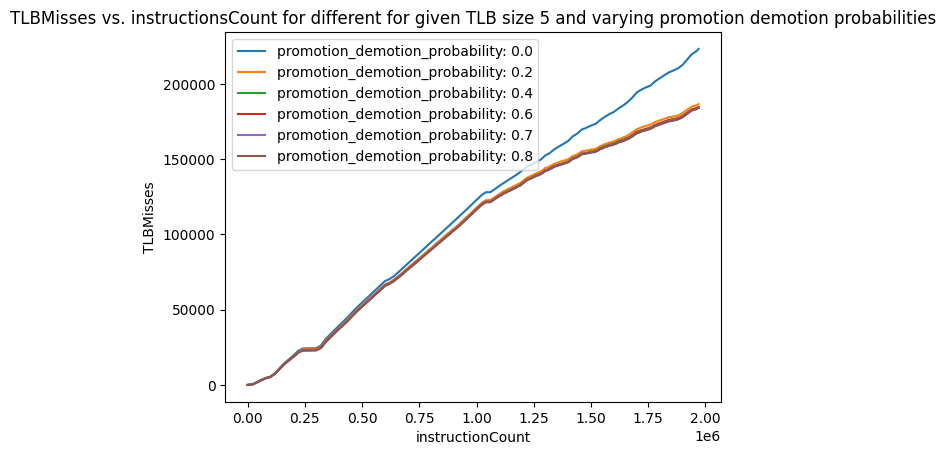

In [59]:
promotion_demotion_probabilities = [0.0,0.2,0.4,0.6,0.7,0.8]
tlb_size = 5
for promotion_demotion_probability in promotion_demotion_probabilities:
    instructionCount, tlbMisses = main(trace_limit=10000,
                                       promotion_demotion_probability=promotion_demotion_probability,
                                       batch_instruction_size=1000,
                                       tlbSize=tlb_size,
                                       stlbSize=tlb_size
                                       )
    plt.plot(instructionCount, tlbMisses, label=f'promotion_demotion_probability: {promotion_demotion_probability}')
plt.xlabel('instructionCount')
plt.ylabel('TLBMisses')
plt.title(f'TLBMisses vs. instructionsCount for different for given TLB size {tlb_size} and varying promotion demotion probabilities')
# Displaying legend
plt.legend()

# Displaying the plot
plt.show()

Running 00K instruction/1980K
Promotion Demotion execution time: 6.9141387939453125e-06
Running 00K instruction/1980K
Promotion Demotion execution time: 0.00020003318786621094
Promotion Demotion execution time: 0.00026106834411621094
Promotion Demotion execution time: 0.0003571510314941406
Promotion Demotion execution time: 0.00034880638122558594
Promotion Demotion execution time: 0.0003361701965332031
Promotion Demotion execution time: 0.0005679130554199219
Promotion Demotion execution time: 0.0007529258728027344
Running 10K instruction/1980K
Promotion Demotion execution time: 0.0008671283721923828
Promotion Demotion execution time: 0.000843048095703125
Running 20K instruction/1980K
Promotion Demotion execution time: 0.001043081283569336
Promotion Demotion execution time: 0.0008566379547119141
Promotion Demotion execution time: 0.0008730888366699219
Promotion Demotion execution time: 0.0008738040924072266
Promotion Demotion execution time: 0.000911712646484375
Promotion Demotion execu

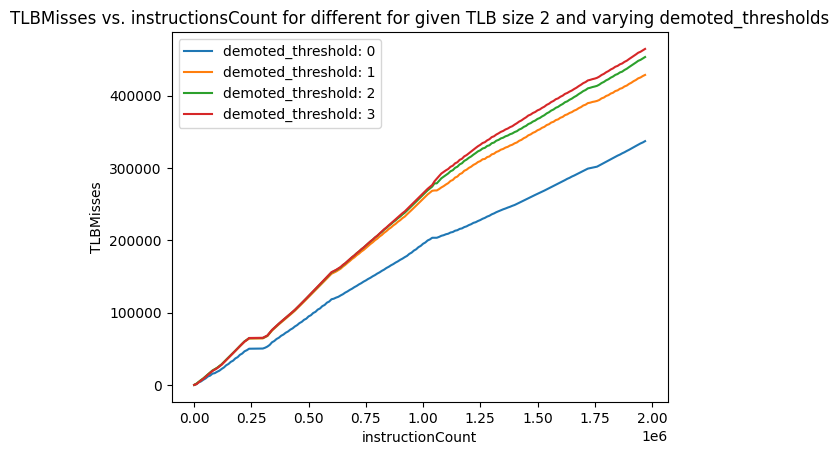

In [70]:
demoted_thresholds = [0,1,2,3]
tlb_size = 5
for demoted_threshold in demoted_thresholds:
    instructionCount, tlbMisses = main(trace_limit=10000,
                                       promotion_demotion_probability=0.5,
                                       batch_instruction_size=1000,
                                       tlbSize=tlb_size,
                                       stlbSize=tlb_size,
                                       demoted_threshold=demoted_threshold
                                       )
    plt.plot(instructionCount, tlbMisses, label=f'demoted_threshold: {demoted_threshold}')
plt.xlabel('instructionCount')
plt.ylabel('TLBMisses')
plt.title(f'TLBMisses vs. instructionsCount for different for given TLB size {tlb_size} and varying demoted_thresholds')
# Displaying legend
plt.legend()

# Displaying the plot
plt.show()

Running 00K instruction/1980K
Promotion Demotion execution time: 5.0067901611328125e-06
Running 00K instruction/1980K
Promotion Demotion execution time: 1.1920928955078125e-06
Running 00K instruction/1980K
Promotion Demotion execution time: 0.0
Running 00K instruction/1980K
Promotion Demotion execution time: 9.393692016601562e-05
Promotion Demotion execution time: 8.869171142578125e-05
Promotion Demotion execution time: 8.7738037109375e-05
Promotion Demotion execution time: 8.821487426757812e-05
Promotion Demotion execution time: 8.797645568847656e-05
Promotion Demotion execution time: 8.702278137207031e-05
Promotion Demotion execution time: 0.00017404556274414062
Promotion Demotion execution time: 0.0002551078796386719
Promotion Demotion execution time: 0.0002560615539550781
Promotion Demotion execution time: 0.00025391578674316406
Promotion Demotion execution time: 0.00035190582275390625
Promotion Demotion execution time: 0.00035119056701660156
Promotion Demotion execution time: 0.00

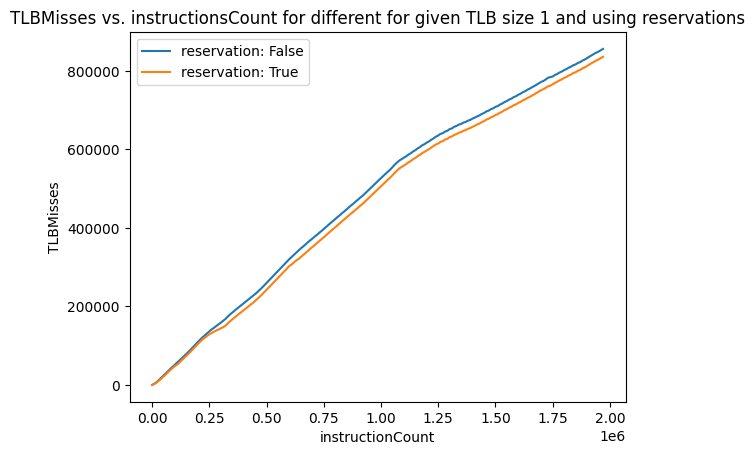

In [8]:
reservations = [False,True]
tlb_size = 1
for reservation in reservations:
    instructionCount, tlbMisses = main(trace_limit=10000,
                                       promotion_demotion_probability=0.5,
                                       batch_instruction_size=1000,
                                       tlbSize=tlb_size,
                                       stlbSize=tlb_size,
                                       demoted_threshold=2,
                                       reservation=reservation
                                       )
    plt.plot(instructionCount, tlbMisses, label=f'reservation: {reservation}')
plt.xlabel('instructionCount')
plt.ylabel('TLBMisses')
plt.title(f'TLBMisses vs. instructionsCount for different for given TLB size {tlb_size} and using reservations')
# Displaying legend
plt.legend()

# Displaying the plot
plt.show()